**Collabrative Filtering**

Collaborative filtering is an approach to product recommendations in which recommendations are made based on a user’s product interaction history combined with the interaction history of all other users on a site. Collaborative filtering collects and analyzes massive datasets of user behavior and activities, and mines that data to predict who will purchase what.

**Importing Liraries**

In [ ]:
#Importing Relevant Libraries
import numpy as np
import pandas as pd
import math 
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

**Importing the Dataset**

In [ ]:
movie_df = pd.read_csv("/content/movies.csv")
ratings_df = pd.read_csv("/content/ratings.csv")

**Exploratory Data Analysis**

In [ ]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
genres = {} # create a dictionary to store different genre values

for genre in movie_df['genres']:
    words = genre.split('|')
    for word in words:
        genres[word] = genres.get(word, 0) + 1

Genre count

In [ ]:
genres

{'(no genres listed)': 34,
 'Action': 1828,
 'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Crime': 1199,
 'Documentary': 440,
 'Drama': 4361,
 'Fantasy': 779,
 'Film-Noir': 87,
 'Horror': 978,
 'IMAX': 158,
 'Musical': 334,
 'Mystery': 573,
 'Romance': 1596,
 'Sci-Fi': 980,
 'Thriller': 1894,
 'War': 382,
 'Western': 167}

**Data Wrangling**

Movies with Highest Average ratings

In [ ]:
new_table = ratings_df.merge(movie_df,on = 'movieId').groupby('title').mean().reset_index()[['title','rating']]
new_table = new_table.sort_values('rating',ascending = False).set_index('title').head(10)

,rating
title,
Gena the Crocodile (1969),5.0
True Stories (1986),5.0
Cosmic Scrat-tastrophe (2015),5.0
Love and Pigeons (1985),5.0
Red Sorghum (Hong gao liang) (1987),5.0
"Thin Line Between Love and Hate, A (1996)",5.0
Lesson Faust (1994),5.0
Eva (2011),5.0
Who Killed Chea Vichea? (2010),5.0


Most Rated Movies

In [ ]:
new_table = ratings_df.merge(movie_df,on = 'movieId').groupby('title').count().reset_index()[['title','rating']].sort_values('rating',ascending = False).head(10)
new_table = new_table.rename(columns={"title": "Title", "rating": "Movie Count"}, errors="raise")
new_table.set_index('Title')

,Movie Count
Title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


**Creating a User Item Matrix for Collabrative Filtering( Also known as Utility Matrix)**

In [ ]:
Combined_table = pd.merge(ratings_df, movie_df, on = 'movieId')
util_mat = Combined_table.pivot_table(index = 'userId', columns = 'title', values = 'rating')
util_mat.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


There are multiple ways in which Collabrative filtering can be used.

1. User - User Similarity

2. Item - Item Similarity


There are three methods used for calculating similarity:

1. Cosine (Most Used)

2. Jaccard

3. Pearson

In [ ]:
#User - User Similarity : For this pearson correlation will be used
user_util_matrix = util_mat.copy()
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


Let's have a look at the correlation:


In [ ]:
user_util_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.264516e-03,5.525772e-04,0.048419,0.021847,-0.045497,-6.199672e-03,0.047013,1.950985e-02,-8.754088e-03,...,0.018127,-0.017172,-0.015221,-3.705875e-02,-2.912138e-02,0.012016,0.055261,0.075224,-2.571255e-02,0.010932
2,0.001265,1.000000e+00,-4.975816e-17,-0.017164,0.021796,-0.021051,-1.111357e-02,-0.048085,7.652805e-16,3.011629e-03,...,-0.050551,-0.031581,-0.001688,-1.265569e-15,-6.430371e-16,0.006226,-0.020504,-0.006001,-6.009100e-02,0.024999
3,0.000553,-4.975816e-17,1.000000e+00,-0.011260,-0.031539,0.004800,-2.587070e-16,-0.032471,-4.812885e-16,3.774064e-16,...,-0.004904,-0.016117,0.017749,-8.106536e-16,-1.430628e-03,-0.037289,-0.007789,-0.013001,-1.168878e-16,0.019550
4,0.048419,-1.716402e-02,-1.125978e-02,1.000000,-0.029620,0.013956,5.809139e-02,0.002065,-5.873603e-03,5.159032e-02,...,-0.037687,0.063122,0.027640,-1.378212e-02,4.003747e-02,0.020590,0.014628,-0.037569,-1.788358e-02,-0.000995
5,0.021847,2.179571e-02,-3.153892e-02,-0.029620,1.000000,0.009111,1.011715e-02,-0.012284,7.750436e-16,-3.316512e-02,...,0.015964,0.012427,0.027076,1.246135e-02,-3.627206e-02,0.026319,0.031896,-0.001751,9.382892e-02,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,6.225827e-03,-3.728895e-02,0.020590,0.026319,-0.009137,2.832591e-02,0.022277,3.163273e-02,-3.994577e-02,...,0.053683,0.016384,0.098011,6.107833e-02,1.967830e-02,1.000000,0.017927,0.056676,3.842210e-02,0.075464
607,0.055261,-2.050374e-02,-7.789105e-03,0.014628,0.031896,0.045501,3.098070e-02,0.048822,-1.216061e-02,-1.765576e-02,...,0.049059,0.038197,0.049317,2.355180e-03,-2.938114e-02,0.017927,1.000000,0.044514,1.904919e-02,0.021860
608,0.075224,-6.000828e-03,-1.300064e-02,-0.037569,-0.001751,0.021727,2.841409e-02,0.071759,3.278284e-02,-5.199963e-02,...,0.069198,0.051388,0.012801,6.318649e-03,-7.977761e-03,0.056676,0.044514,1.000000,5.071449e-02,0.054454


Now, the way this works is we will consider a user and see which others users have the highest correlation with the user. On the basis of that we will recommend movies to the user.

In [ ]:
user_corr_mat = user_util_matrix.T.corr()
corr_user_1 = user_corr_mat.iloc[0]

In [ ]:
corr_user_1.sort_values(ascending=False, inplace=True)
corr_user_1.head(10)

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
57     0.099070
369    0.098295
206    0.096852
535    0.096493
590    0.095191
Name: 1, dtype: float64

As we can see, we can sort the users in terms of most similar users.

In [ ]:
#Removing NaN values from the list.
corr_user_1.dropna(inplace = True)
# Looking at the top 50 correlated values
top50_corr_users = corr_user_1[1:51]

Having a look at the movies that User 1 has rated

In [ ]:
Combined_table[Combined_table['userId'] == 1]

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
215,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
267,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
369,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
572,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
16056,1,3744,4.0,964980694,Shaft (2000),Action|Crime|Thriller
16075,1,3793,5.0,964981855,X-Men (2000),Action|Adventure|Sci-Fi
16208,1,3809,4.0,964981220,What About Bob? (1991),Comedy
16243,1,4006,4.0,964982903,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [ ]:
# user1 has not rated 23 movie
Combined_table[ (Combined_table['userId'] == 1) & (Combined_table['movieId'] == 32) ] 

,userId,movieId,rating,timestamp,title,genres


In [ ]:
print('32nd Movie : ', movie_df['title'][ movie_df['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


In [ ]:
df_n_ratings = pd.DataFrame(Combined_table.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(Combined_table.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)


,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


In [ ]:
df_n_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


Finding the no. of users in top 50 ratings that have rated the same movie as well

In [ ]:
top50_users = top50_corr_users.keys()
count = 0
users = list()
for user in top50_users:
    if Combined_table[ (Combined_table['userId'] == user) & (Combined_table['movieId'] == 32) ]['rating'].sum() :
        count +=1
        users.append(user)
print(count)

30


30 people have rated this movie. Now, The User has not rated this movie, but we can calculate what would be likely rating by this user using the formula:

Predicted rating = sum of [ (weights) * (ratings) ] / sum of (weights)

Here, weights is the correlation of the corresponding user with the first user.

In [ ]:
top50_corr_users = top50_corr_users.reset_index()

In [ ]:
top50_corr_users[top50_corr_users['userId'] == 301].iloc[:,1].values[0]

0.12479906517911284

In [ ]:
def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users[top50_corr_users['userId'] == user].iloc[:,1].values[0] * Combined_table[ (Combined_table['userId'] == user) & 
                                                              (Combined_table['movieId'] == 32) ]['rating'].sum()
        sum_similarity += top50_corr_users[top50_corr_users['userId'] == user].iloc[:,1].values[0]

    print(weighted_ratings / sum_similarity)
    
    
predict_rating()

4.1368953015974315


In [ ]:
movie_df[movie_df['movieId'] == 32]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


Since the likely rating by the user for the movie is quite high, there is good chance that this movie will be liked by the user. 

This is a simpler version of recommending movies based on user-user profile. There are more complex methods to this that would be discussed further.

**Item - Item Based Filtering method**

This method is very similar to Content Based filtering Method.

We'll now use collabrative filtering method to on Item - Item Based profile.

In [ ]:
#For this task we will movies similar to Jurrassic Park
df_n_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total ratings
title,,
Jurassic Park (1993),3.75,238


In [ ]:
item_util_matrix = util_mat.copy()
item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [ ]:
#For item based match we will fill the NaN ratings column-wise with movie's mean rating.
#we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
6,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
7,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
8,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
9,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,1.000000,2.0,3.134615,1.0


In [ ]:
#Checking if all the NaN values are filled.
item_util_matrix.isna().sum().sum()

0

No Nan values left. It means that every movie has been rated by atleat 1 user.

In [ ]:
item_util_matrix.corr()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.000000e+00,NaN,-2.470228e-17,NaN,-6.783236e-16,-4.090781e-16,...,NaN,1.491400e-15,-2.970631e-18,NaN,NaN,-1.174172e-16,-4.643126e-16,-1.457468e-15,2.901144e-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,-1.174172e-16,NaN,6.069910e-02,NaN,-7.527708e-02,2.947366e-02,...,NaN,-1.447002e-15,-3.196632e-16,NaN,NaN,1.000000e+00,3.784587e-02,1.243849e-15,-3.410933e-02,NaN
xXx (2002),NaN,NaN,NaN,NaN,-4.643126e-16,NaN,-3.527098e-03,NaN,1.558884e-01,2.511177e-01,...,NaN,-2.067568e-01,-4.854206e-03,NaN,NaN,3.784587e-02,1.000000e+00,2.449296e-01,1.854832e-02,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,-1.457468e-15,NaN,6.027298e-16,NaN,1.107823e-01,-1.311693e-15,...,NaN,-2.014024e-01,7.715167e-02,NaN,NaN,1.243849e-15,2.449296e-01,1.000000e+00,1.034849e-15,NaN


We are seeing that there are a lot of NaN values, this is because if the stardard dev. is 0, correlation is not defined so we are seeing a lot of NaN values. Suppose if a movie has only 1 rating, then all other values would be rated as NaN. 

In [ ]:
item_corr_matrix = item_util_matrix.corr()
jurassic_park_corr = item_corr_matrix['Jurassic Park (1993)']
jurassic_park_corr = jurassic_park_corr.sort_values(ascending=False)
jurassic_park_corr.dropna(inplace=True)

In [ ]:
movies_similar_to_jurassic_park = pd.DataFrame(data=jurassic_park_corr.values, columns=['Correlation'], 
                                               index = jurassic_park_corr.index)
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park.join(df_n_ratings['total ratings'])
movies_similar_to_jurassic_park.head(10)

,Correlation,total ratings
title,,
Jurassic Park (1993),1.000000,238
"Fugitive, The (1993)",0.324717,190
Lethal Weapon (1987),0.318646,75
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Mulan (1998),0.255672,45
Rise of the Planet of the Apes (2011),0.248134,27
"Bug's Life, A (1998)",0.240964,92


It would be better if we looked at moves that were rated many times so that we have a generalized output. In this case let's look at the movies only that were rated more than 100 times.

In [ ]:
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park[1:]
movies_similar_to_jurassic_park[ movies_similar_to_jurassic_park['total ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total ratings
title,,
"Fugitive, The (1993)",0.324717,190
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Indiana Jones and the Temple of Doom (1984),0.239826,108
Die Hard (1988),0.239294,145
Aladdin (1992),0.227711,183
Braveheart (1995),0.222085,237
Speed (1994),0.220720,171


So in this case, we can see the movies that are recommend the most: The Fugitive, Independence Day. so if someone likes Jurassic Park, they'll most likely like these movies as well.

Model Based Collabrative Filtering:

We can multiple ways with the help of which we can go about this task.

1. K Nearest Neighbors

2. SVD( U-V Factorization)

3. Non - Negative Matrix Factorization( This is widely used because SVD can often result in negative reviews which is not practical).

4. Deep Learning based Approach

For this task we will use a library known 'surprise'(This library is built upon Scikit Learn). This is a widely used library for Model - Based Recommendation System.

In [ ]:
!apt-get -qq install -y graphviz && pip install surprise

     |████████████████████████████████| 11.8 MB 5.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630167 sha256=d89cbac8e5df5db15b01048be9aaaa6c3c67252127d1440707381408afe845e0
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
#surprise is a library built upon Scikit-Learn
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

In [ ]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( ratings_df[['userId', 'movieId', 'rating']], reader = reader )

**1. K Nearest Neighbors**

In [ ]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
scross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9461  0.9488  0.9394  0.9331  0.9377  0.9410  0.0057  
Fit time          0.18    0.20    0.19    0.21    0.20    0.20    0.01    
Test time         1.48    1.41    1.40    1.55    1.59    1.48    0.08    


{'fit_time': (0.17847156524658203,
  0.19818806648254395,
  0.19149041175842285,
  0.2125561237335205,
  0.19778203964233398),
 'test_rmse': array([0.94605547, 0.94882761, 0.93935637, 0.93305207, 0.93767246]),
 'test_time': (1.4753978252410889,
  1.408601999282837,
  1.3987014293670654,
  1.5512244701385498,
  1.5892717838287354)}

**Hyperparameter Tuning**

To find the best parameters, we will use Grid Search with Cross Validation.

In [ ]:
n_neighbours = [5,10,15,20]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

**2. Singular Value Decompostion ( U - V Factorization)**

In [ ]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8737  0.8766  0.8764  0.8729  0.8680  0.8735  0.0031  
Fit time          6.75    5.29    5.44    5.67    5.41    5.71    0.53    
Test time         0.17    0.34    0.16    0.34    0.16    0.23    0.09    


{'fit_time': (6.752148389816284,
  5.28718900680542,
  5.441238880157471,
  5.672626733779907,
  5.40647029876709),
 'test_rmse': array([0.87371726, 0.87658869, 0.87644659, 0.87292017, 0.86800736]),
 'test_time': (0.16679883003234863,
  0.34415292739868164,
  0.15573573112487793,
  0.33502888679504395,
  0.16132616996765137)}

Fine tuning the SVD parameters to see which algorithm would give the best result.

In [ ]:
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 0.863326843756532
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


These are the best Parameters for SVD.

**3. Non - Negative Matrix Factorization**

In [ ]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9168  0.9315  0.9283  0.9144  0.9153  0.9213  0.0072  
Fit time          8.08    7.90    8.09    7.48    8.05    7.92    0.23    
Test time         0.14    0.15    0.15    0.28    0.14    0.17    0.05    


{'fit_time': (8.075997352600098,
  7.90085506439209,
  8.086294889450073,
  7.478613615036011,
  8.045268535614014),
 'test_rmse': array([0.9167724 , 0.93149619, 0.92831212, 0.91443083, 0.91530163]),
 'test_time': (0.1422441005706787,
  0.15163636207580566,
  0.1499021053314209,
  0.2792794704437256,
  0.1382160186767578)}

**Deep Learning based Model**

We would use Keras for Most of the Model we build.

In [ ]:
from keras.layers import Embedding, Input, dot, concatenate,Flatten,Dense
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Splitting the Data for evaluation

In [ ]:
X = ratings_df.iloc[:,:2]
Y = ratings_df.iloc[:,2]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

We would need to embedded User and Item Profiles, this is important because since there are only a few moies for a paticular individual that is rated, recommendation system suffer from a phenomenon known as the curse of dimensionality. To deal with that we perform emedding so that we can have a continous vector, which would then give much more and hidden information about the entities.

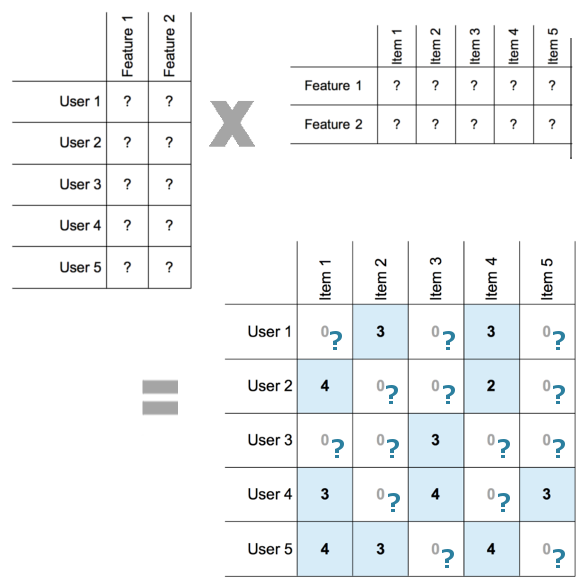

From the image it can be observed that, there are specific features that can be attributed to a user and to Item as well. 

This can give much more information about user and item profiles:

1. Let's say for item profiles:
    1. To what scale it is an Drama Movie.
    2. When was the movie released?
2. Let's say for user profile
    1. How much a person likes Drama Movies.
    2. Whether the user likes old movies?

Using this method we can much more information( but implicitly).

From this we can take a dot product to calculate a users movie rating.

Estimated Rating = [ (To what scale it is an Drama Movie.) x (How much a person likes Drama Movies.) ] + [ (Whether the user likes old movies?) x (When was the movie released?) ]
       

In [ ]:
# The number of latent factors for the embedding
n_latent_factors = 50

# no of users and movies
n_users, n_movies = len(ratings_df['userId'].unique()), len(ratings_df['movieId'].unique()) 

### First Architecture 

In [ ]:
# Model Architecture


# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model = Model([user_input, movie_input], merged_vectors)

Visualing the model architecture

In [ ]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        30500       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        486200      ['Movie_Input[0][0]']            
                                                                                              

4.5) Compiling the Model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mean_squared_error', optimizer = opt)

Fitting the model

In [ ]:
x_train['userId'] 

98062    606
62414    414
19355    125
10070     66
42674    288
        ... 
50893    328
62586    414
8243      57
8823      62
91156    590
Name: userId, Length: 80668, dtype: int64

In [ ]:
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size = 128, epochs=20, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

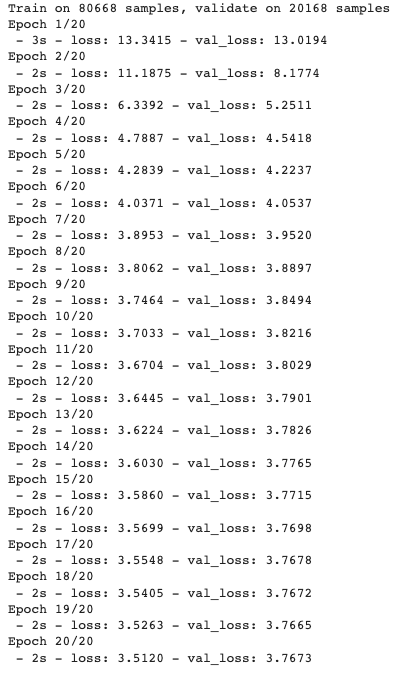

Visualising our results

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

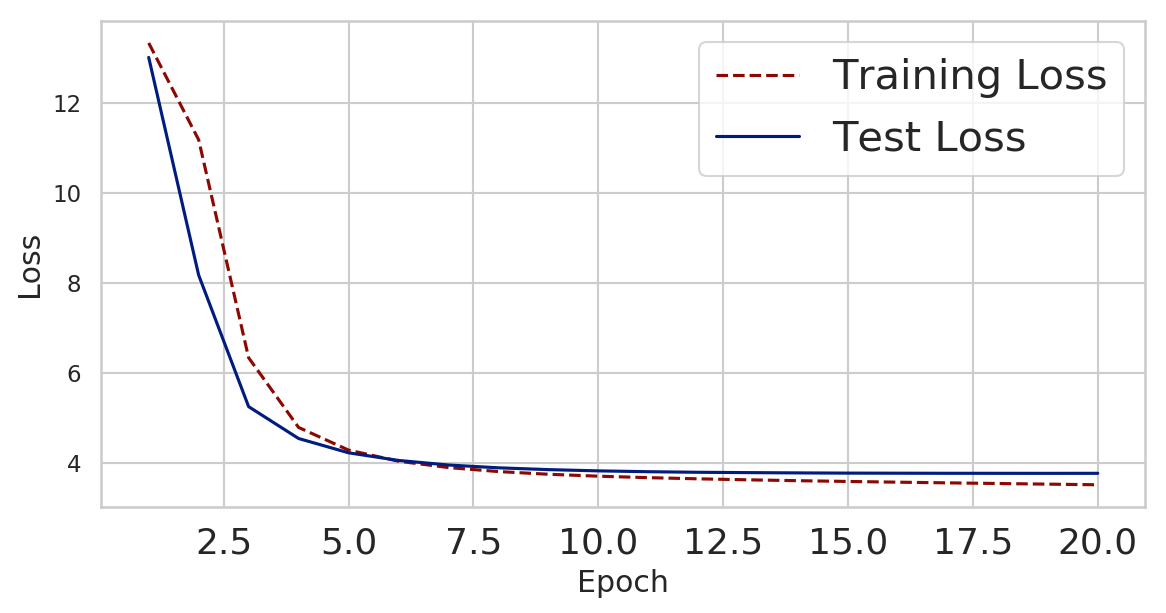

Second Architecture

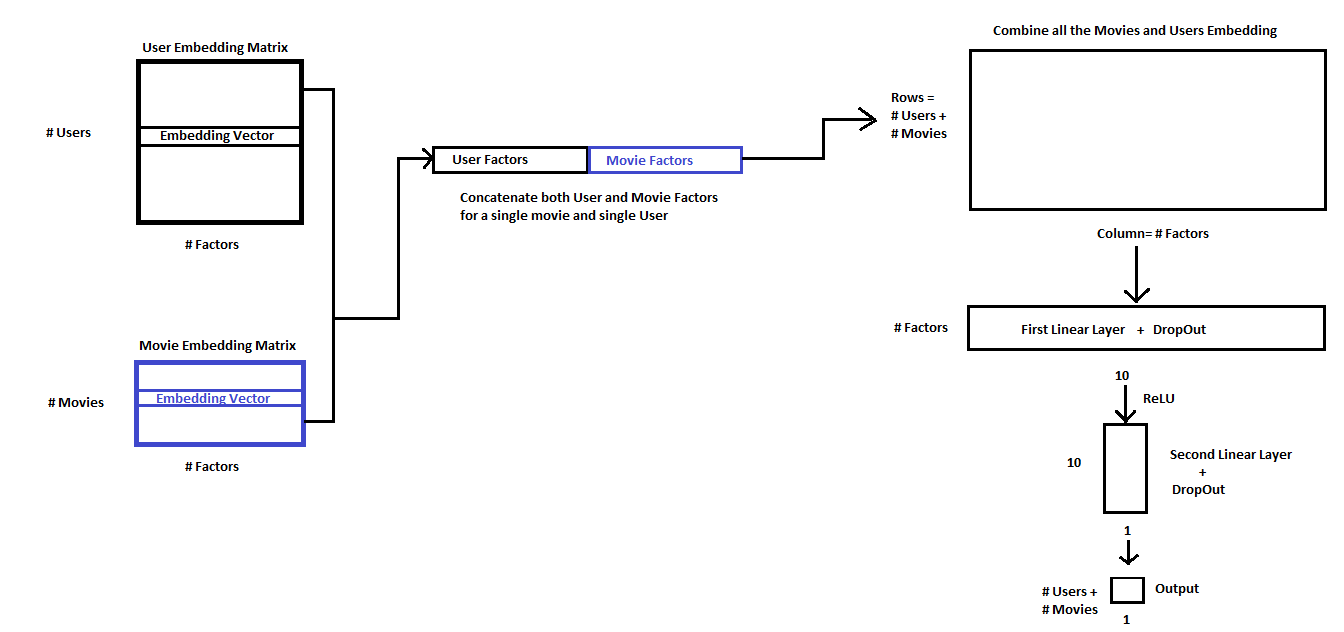

In [ ]:
# Model Architecture


# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)



# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, 
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)




# Concatenate Product
merged_vectors = concatenate([user_vector, movie_vector], name='Concantenate')
dense_layer_1 = Dense(100, activation='relu')(merged_vectors) 
# dense_layer_1 = Dropout(0.25) (dense_layer_1)
# batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
# dense_layer_2 = Dense(64, activation='relu')(merged_vectors)


result = Dense(1)(dense_layer_1)
model = Model([user_input, movie_input], result)

Visualising the Model Architecture

In [ ]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie_Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 50)        30500       ['User_Input[0][0]']             
                                                                                                  
 Movie_Embedding (Embedding)    (None, 1, 50)        486200      ['Movie_Input[0][0]']            
                                                                                            

Model compilation

In [ ]:
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate=0.0005))

Fitting the Model

In [ ]:
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size= 128, epochs=20, 
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

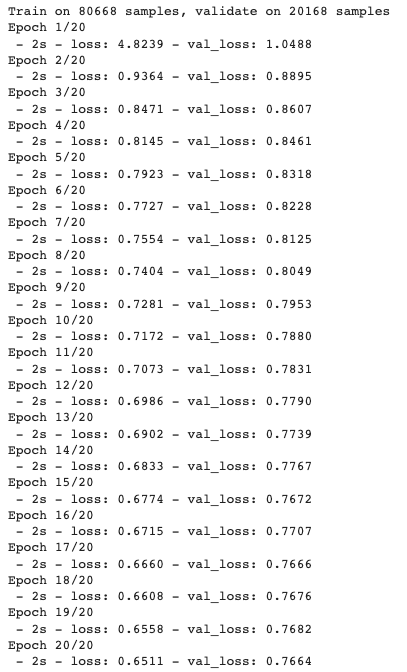

Plotting Validation Curve

In [ ]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

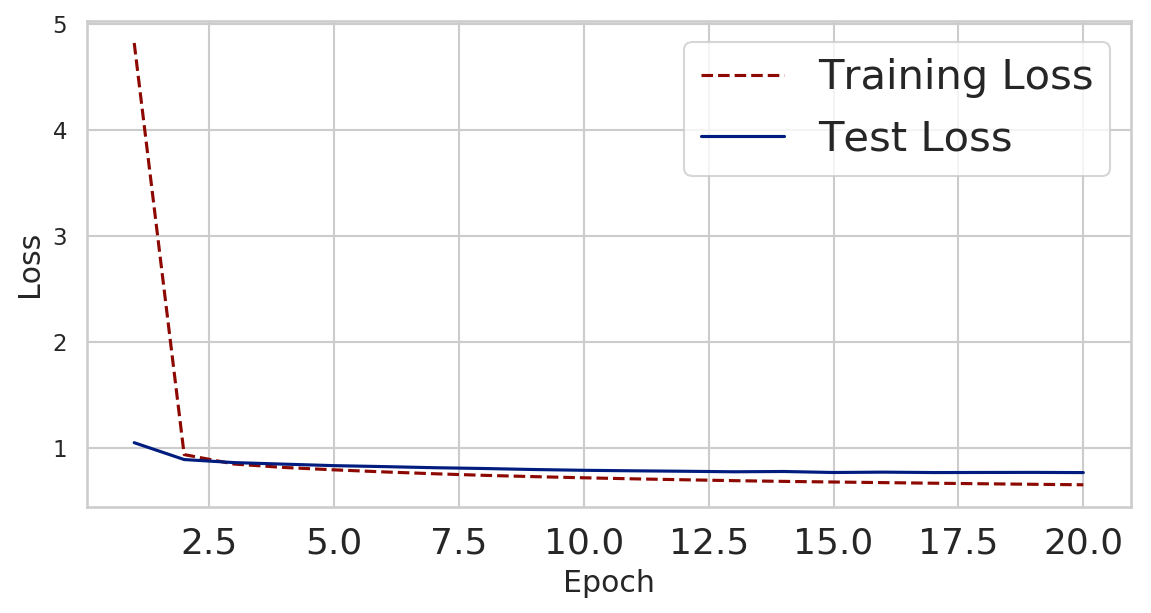

RMSE for the model: 0.8754